# Learning XOR with Pytorch

This notebook provides a neural network that learns the XOR logic operation:

|   x1  |   x2  |  y  |
|:-----:|:-----:|:---:|
|   1   |   1   |  0  |
|   1   |   0   |  1  |
|   0   |   1   |  1  |
|   0   |   0   |  0  |

This example is will provide an insight into a simple neural network and, at the same time, a gentle introduction to [PyTorch](https://pytorch.org).

## Importing the libraries

In [1]:
# import libraries 
import torch
import torch.nn as nn
from torch.autograd import Variable

## Device

PyTorch can use both CPU or GPU, depending on what is available:

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


## Dataset

The training dataset is composed of the inputs and required outputs of the neural network. In this case, the inputs are represented in a [tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) of $4 \times 2$ dimension and the output (labels) in a $4 \times 1$ tensor.

Tensors are a specialized data structure that are very similar to arrays and matrices. In PyTorch, tensors are used to encode the inputs and outputs of a model, as well as the model’s parameters. We are also using a [`Dataset`](https://pytorch.org/docs/1.10.0/data.html#iterable-style-datasets) with the `DataLoader` to iterate the training set.

In [3]:
from torch.utils.data import Dataset

class XorDataset(Dataset):
    def __init__(self):
        self.Xs = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])
        self.y = torch.Tensor([0., 1., 1., 0.])
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        image = self.Xs[idx]
        label = self.y[idx]
        return image, label
    


In [4]:
from torch.utils.data import DataLoader

training_data = XorDataset()
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False)

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
feature = train_features[0].squeeze()
label = train_labels[0]
print(f"Features: {feature}; Label: {label}")

Feature batch shape: torch.Size([1, 2])
Labels batch shape: torch.Size([1])
Features: tensor([0., 0.]); Label: 0.0


## Neural Network

The neural network is defined by subclassing `nn.Module`, and initialize the neural network layers in `__init__`. Every `nn.Module` subclass implements the operations on input data in the `forward` method.

For the XOR network, we need two layers (refer to the slides).

In [6]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear_xor_stack = nn.Sequential(
            nn.Linear(2, 2),
            nn.Sigmoid(),
            nn.Linear(2, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_xor_stack(x)
        return logits

The neural network is instanciated by creating the class and associating it to a processing device:

In [7]:
xor_network = XOR()
model = xor_network.to(device)
print(model)

XOR(
  (linear_xor_stack): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


After the definition of the dataset and model architecture, we can train the network. We're using backpropagation, as depicted below:

In [8]:
from torch.utils.data import DataLoader
all_losses=[]
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    all_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")   

We are using Min Square Error loss function and Stochastic Gradient Descent for training with 2000 epochs.

In [9]:
learning_rate = 1
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 2000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(train_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.382937  [    0/    4]
loss: 0.247359  [    1/    4]
loss: 0.124638  [    2/    4]
loss: 0.512060  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.253321 

Epoch 2
-------------------------------
loss: 0.296733  [    0/    4]
loss: 0.317264  [    1/    4]
loss: 0.170636  [    2/    4]
loss: 0.456664  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.249746 

Epoch 3
-------------------------------
loss: 0.254814  [    0/    4]
loss: 0.353698  [    1/    4]
loss: 0.199058  [    2/    4]
loss: 0.425608  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.249313 

Epoch 4
-------------------------------
loss: 0.235070  [    0/    4]
loss: 0.371530  [    1/    4]
loss: 0.214821  [    2/    4]
loss: 0.408386  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.249436 

Epoch 5
-------------------------------
loss: 0.225820  [    0/    4]
loss: 0.379927  [    1/    4]
loss: 0.223282  [    2/    4]
loss: 0.398523  [    3

/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.252277  [    0/    4]
loss: 0.359171  [    1/    4]
loss: 0.225140  [    2/    4]
loss: 0.305958  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.247471 

Epoch 74
-------------------------------
loss: 0.252299  [    0/    4]
loss: 0.359441  [    1/    4]
loss: 0.224581  [    2/    4]
loss: 0.305492  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.247367 

Epoch 75
-------------------------------
loss: 0.252306  [    0/    4]
loss: 0.359740  [    1/    4]
loss: 0.224001  [    2/    4]
loss: 0.305024  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.247258 

Epoch 76
-------------------------------
loss: 0.252299  [    0/    4]
loss: 0.360066  [    1/    4]
loss: 0.223398  [    2/    4]
loss: 0.304552  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.247143 

Epoch 77
-------------------------------
loss: 0.252277  [    0/    4]
loss: 0.360422  [    1/    4]
loss: 0.222771  [    2/    4]
loss: 0.304076  [    3/    4]
Test Error: 
 Accuracy: 50.0

loss: 0.173202  [    0/    4]
loss: 0.481352  [    1/    4]
loss: 0.083851  [    2/    4]
loss: 0.196310  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.207036 

Epoch 147
-------------------------------
loss: 0.171156  [    0/    4]
loss: 0.483402  [    1/    4]
loss: 0.081504  [    2/    4]
loss: 0.194043  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.206208 

Epoch 148
-------------------------------
loss: 0.169143  [    0/    4]
loss: 0.485381  [    1/    4]
loss: 0.079216  [    2/    4]
loss: 0.191832  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.205394 

Epoch 149
-------------------------------
loss: 0.167165  [    0/    4]
loss: 0.487288  [    1/    4]
loss: 0.076990  [    2/    4]
loss: 0.189678  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.204596 

Epoch 150
-------------------------------
loss: 0.165223  [    0/    4]
loss: 0.489122  [    1/    4]
loss: 0.074826  [    2/    4]
loss: 0.187585  [    3/    4]
Test Error: 
 Accuracy: 

loss: 0.152463  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.170621 

Epoch 220
-------------------------------
loss: 0.097924  [    0/    4]
loss: 0.484649  [    1/    4]
loss: 0.019923  [    2/    4]
loss: 0.152826  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.170105 

Epoch 221
-------------------------------
loss: 0.097272  [    0/    4]
loss: 0.483073  [    1/    4]
loss: 0.019827  [    2/    4]
loss: 0.153194  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.169572 

Epoch 222
-------------------------------
loss: 0.096615  [    0/    4]
loss: 0.481433  [    1/    4]
loss: 0.019745  [    2/    4]
loss: 0.153566  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.169022 

Epoch 223
-------------------------------
loss: 0.095955  [    0/    4]
loss: 0.479724  [    1/    4]
loss: 0.019677  [    2/    4]
loss: 0.153937  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.168452 

Epoch 224
-------------------------------
loss: 0.095291  [   

loss: 0.014776  [    2/    4]
loss: 0.020457  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.027232 

Epoch 295
-------------------------------
loss: 0.031279  [    0/    4]
loss: 0.052102  [    1/    4]
loss: 0.014521  [    2/    4]
loss: 0.019878  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.026494 

Epoch 296
-------------------------------
loss: 0.030403  [    0/    4]
loss: 0.050382  [    1/    4]
loss: 0.014272  [    2/    4]
loss: 0.019328  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.025789 

Epoch 297
-------------------------------
loss: 0.029566  [    0/    4]
loss: 0.048754  [    1/    4]
loss: 0.014029  [    2/    4]
loss: 0.018805  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.025115 

Epoch 298
-------------------------------
loss: 0.028766  [    0/    4]
loss: 0.047211  [    1/    4]
loss: 0.013792  [    2/    4]
loss: 0.018307  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.024472 

Epoch 299
----------------------

loss: 0.008727  [    0/    4]
loss: 0.012541  [    1/    4]
loss: 0.005774  [    2/    4]
loss: 0.005986  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.007960 

Epoch 370
-------------------------------
loss: 0.008635  [    0/    4]
loss: 0.012398  [    1/    4]
loss: 0.005724  [    2/    4]
loss: 0.005927  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.007880 

Epoch 371
-------------------------------
loss: 0.008544  [    0/    4]
loss: 0.012258  [    1/    4]
loss: 0.005675  [    2/    4]
loss: 0.005869  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.007801 

Epoch 372
-------------------------------
loss: 0.008455  [    0/    4]
loss: 0.012121  [    1/    4]
loss: 0.005626  [    2/    4]
loss: 0.005812  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.007724 

Epoch 373
-------------------------------
loss: 0.008368  [    0/    4]
loss: 0.011987  [    1/    4]
loss: 0.005579  [    2/    4]
loss: 0.005756  [    3/    4]
Test Error: 
 Accuracy: 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.004365 

Epoch 448
-------------------------------
loss: 0.004630  [    0/    4]
loss: 0.006403  [    1/    4]
loss: 0.003378  [    2/    4]
loss: 0.003310  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.004339 

Epoch 449
-------------------------------
loss: 0.004602  [    0/    4]
loss: 0.006362  [    1/    4]
loss: 0.003360  [    2/    4]
loss: 0.003291  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.004314 

Epoch 450
-------------------------------
loss: 0.004574  [    0/    4]
loss: 0.006321  [    1/    4]
loss: 0.003342  [    2/    4]
loss: 0.003272  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.004288 

Epoch 451
-------------------------------
loss: 0.004546  [    0/    4]
loss: 0.006281  [    1/    4]
loss: 0.003324  [    2/    4]
loss: 0.003253  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.004264 

Epoch 452
-------------------------------
loss: 0.004519  [    0/    4]
loss: 0.006241  [   

loss: 0.002476  [    2/    4]
loss: 0.002377  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.003093 

Epoch 516
-------------------------------
loss: 0.003247  [    0/    4]
loss: 0.004422  [    1/    4]
loss: 0.002466  [    2/    4]
loss: 0.002367  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.003079 

Epoch 517
-------------------------------
loss: 0.003233  [    0/    4]
loss: 0.004401  [    1/    4]
loss: 0.002456  [    2/    4]
loss: 0.002357  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.003066 

Epoch 518
-------------------------------
loss: 0.003219  [    0/    4]
loss: 0.004381  [    1/    4]
loss: 0.002446  [    2/    4]
loss: 0.002347  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.003053 

Epoch 519
-------------------------------
loss: 0.003205  [    0/    4]
loss: 0.004361  [    1/    4]
loss: 0.002437  [    2/    4]
loss: 0.002337  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.003040 

Epoch 520
----------------------

-------------------------------
loss: 0.002416  [    0/    4]
loss: 0.003257  [    1/    4]
loss: 0.001886  [    2/    4]
loss: 0.001786  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.002310 

Epoch 593
-------------------------------
loss: 0.002408  [    0/    4]
loss: 0.003245  [    1/    4]
loss: 0.001880  [    2/    4]
loss: 0.001780  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.002302 

Epoch 594
-------------------------------
loss: 0.002400  [    0/    4]
loss: 0.003234  [    1/    4]
loss: 0.001874  [    2/    4]
loss: 0.001775  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.002295 

Epoch 595
-------------------------------
loss: 0.002392  [    0/    4]
loss: 0.003223  [    1/    4]
loss: 0.001868  [    2/    4]
loss: 0.001769  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.002287 

Epoch 596
-------------------------------
loss: 0.002384  [    0/    4]
loss: 0.003212  [    1/    4]
loss: 0.001862  [    2/    4]
loss: 0.001763  [    3

loss: 0.002529  [    1/    4]
loss: 0.001503  [    2/    4]
loss: 0.001411  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001817 

Epoch 674
-------------------------------
loss: 0.001884  [    0/    4]
loss: 0.002522  [    1/    4]
loss: 0.001499  [    2/    4]
loss: 0.001407  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001812 

Epoch 675
-------------------------------
loss: 0.001879  [    0/    4]
loss: 0.002515  [    1/    4]
loss: 0.001495  [    2/    4]
loss: 0.001404  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001807 

Epoch 676
-------------------------------
loss: 0.001874  [    0/    4]
loss: 0.002508  [    1/    4]
loss: 0.001492  [    2/    4]
loss: 0.001400  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001802 

Epoch 677
-------------------------------
loss: 0.001869  [    0/    4]
loss: 0.002501  [    1/    4]
loss: 0.001488  [    2/    4]
loss: 0.001396  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001797 

Ep

loss: 0.002060  [    1/    4]
loss: 0.001247  [    2/    4]
loss: 0.001163  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001493 

Epoch 755
-------------------------------
loss: 0.001542  [    0/    4]
loss: 0.002055  [    1/    4]
loss: 0.001244  [    2/    4]
loss: 0.001161  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001490 

Epoch 756
-------------------------------
loss: 0.001539  [    0/    4]
loss: 0.002050  [    1/    4]
loss: 0.001242  [    2/    4]
loss: 0.001158  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001486 

Epoch 757
-------------------------------
loss: 0.001536  [    0/    4]
loss: 0.002046  [    1/    4]
loss: 0.001239  [    2/    4]
loss: 0.001156  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001483 

Epoch 758
-------------------------------
loss: 0.001532  [    0/    4]
loss: 0.002041  [    1/    4]
loss: 0.001236  [    2/    4]
loss: 0.001153  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001480 

Ep

loss: 0.001303  [    0/    4]
loss: 0.001731  [    1/    4]
loss: 0.001062  [    2/    4]
loss: 0.000987  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001263 

Epoch 837
-------------------------------
loss: 0.001301  [    0/    4]
loss: 0.001727  [    1/    4]
loss: 0.001060  [    2/    4]
loss: 0.000985  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001260 

Epoch 838
-------------------------------
loss: 0.001298  [    0/    4]
loss: 0.001724  [    1/    4]
loss: 0.001058  [    2/    4]
loss: 0.000983  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001258 

Epoch 839
-------------------------------
loss: 0.001296  [    0/    4]
loss: 0.001720  [    1/    4]
loss: 0.001056  [    2/    4]
loss: 0.000981  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001255 

Epoch 840
-------------------------------
loss: 0.001293  [    0/    4]
loss: 0.001717  [    1/    4]
loss: 0.001054  [    2/    4]
loss: 0.000979  [    3/    4]
Test Error: 
 Accuracy: 

loss: 0.001127  [    0/    4]
loss: 0.001492  [    1/    4]
loss: 0.000925  [    2/    4]
loss: 0.000857  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001094 

Epoch 918
-------------------------------
loss: 0.001125  [    0/    4]
loss: 0.001490  [    1/    4]
loss: 0.000924  [    2/    4]
loss: 0.000855  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001092 

Epoch 919
-------------------------------
loss: 0.001123  [    0/    4]
loss: 0.001487  [    1/    4]
loss: 0.000922  [    2/    4]
loss: 0.000854  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001091 

Epoch 920
-------------------------------
loss: 0.001121  [    0/    4]
loss: 0.001485  [    1/    4]
loss: 0.000921  [    2/    4]
loss: 0.000853  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.001089 

Epoch 921
-------------------------------
loss: 0.001119  [    0/    4]
loss: 0.001482  [    1/    4]
loss: 0.000920  [    2/    4]
loss: 0.000851  [    3/    4]
Test Error: 
 Accuracy: 

loss: 0.000762  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000972 

Epoch 994
-------------------------------
loss: 0.000997  [    0/    4]
loss: 0.001318  [    1/    4]
loss: 0.000824  [    2/    4]
loss: 0.000761  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000970 

Epoch 995
-------------------------------
loss: 0.000995  [    0/    4]
loss: 0.001316  [    1/    4]
loss: 0.000823  [    2/    4]
loss: 0.000760  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000969 

Epoch 996
-------------------------------
loss: 0.000994  [    0/    4]
loss: 0.001314  [    1/    4]
loss: 0.000822  [    2/    4]
loss: 0.000759  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000968 

Epoch 997
-------------------------------
loss: 0.000992  [    0/    4]
loss: 0.001312  [    1/    4]
loss: 0.000821  [    2/    4]
loss: 0.000758  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000966 

Epoch 998
-------------------------------
loss: 0.000991  [   

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000877 

Epoch 1067
-------------------------------
loss: 0.000898  [    0/    4]
loss: 0.001186  [    1/    4]
loss: 0.000746  [    2/    4]
loss: 0.000688  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000876 

Epoch 1068
-------------------------------
loss: 0.000897  [    0/    4]
loss: 0.001185  [    1/    4]
loss: 0.000745  [    2/    4]
loss: 0.000687  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000875 

Epoch 1069
-------------------------------
loss: 0.000896  [    0/    4]
loss: 0.001183  [    1/    4]
loss: 0.000744  [    2/    4]
loss: 0.000686  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000873 

Epoch 1070
-------------------------------
loss: 0.000895  [    0/    4]
loss: 0.001181  [    1/    4]
loss: 0.000743  [    2/    4]
loss: 0.000685  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000872 

Epoch 1071
-------------------------------
loss: 0.000893  [    0/    4]
loss: 0.001180 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000799 

Epoch 1140
-------------------------------
loss: 0.000817  [    0/    4]
loss: 0.001078  [    1/    4]
loss: 0.000682  [    2/    4]
loss: 0.000627  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000798 

Epoch 1141
-------------------------------
loss: 0.000816  [    0/    4]
loss: 0.001076  [    1/    4]
loss: 0.000681  [    2/    4]
loss: 0.000626  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000797 

Epoch 1142
-------------------------------
loss: 0.000815  [    0/    4]
loss: 0.001075  [    1/    4]
loss: 0.000680  [    2/    4]
loss: 0.000626  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000796 

Epoch 1143
-------------------------------
loss: 0.000814  [    0/    4]
loss: 0.001074  [    1/    4]
loss: 0.000679  [    2/    4]
loss: 0.000625  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000795 

Epoch 1144
-------------------------------
loss: 0.000813  [    0/    4]
loss: 0.001072 

loss: 0.000631  [    2/    4]
loss: 0.000580  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000737 

Epoch 1208
-------------------------------
loss: 0.000753  [    0/    4]
loss: 0.000993  [    1/    4]
loss: 0.000631  [    2/    4]
loss: 0.000579  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000736 

Epoch 1209
-------------------------------
loss: 0.000752  [    0/    4]
loss: 0.000991  [    1/    4]
loss: 0.000630  [    2/    4]
loss: 0.000579  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000735 

Epoch 1210
-------------------------------
loss: 0.000751  [    0/    4]
loss: 0.000990  [    1/    4]
loss: 0.000629  [    2/    4]
loss: 0.000578  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000735 

Epoch 1211
-------------------------------
loss: 0.000751  [    0/    4]
loss: 0.000989  [    1/    4]
loss: 0.000628  [    2/    4]
loss: 0.000578  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000734 

Epoch 1212
-----------------

loss: 0.000916  [    1/    4]
loss: 0.000584  [    2/    4]
loss: 0.000536  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000681 

Epoch 1281
-------------------------------
loss: 0.000695  [    0/    4]
loss: 0.000915  [    1/    4]
loss: 0.000583  [    2/    4]
loss: 0.000536  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000680 

Epoch 1282
-------------------------------
loss: 0.000694  [    0/    4]
loss: 0.000914  [    1/    4]
loss: 0.000583  [    2/    4]
loss: 0.000535  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000679 

Epoch 1283
-------------------------------
loss: 0.000693  [    0/    4]
loss: 0.000913  [    1/    4]
loss: 0.000582  [    2/    4]
loss: 0.000534  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000678 

Epoch 1284
-------------------------------
loss: 0.000693  [    0/    4]
loss: 0.000912  [    1/    4]
loss: 0.000582  [    2/    4]
loss: 0.000534  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000678 

loss: 0.000645  [    0/    4]
loss: 0.000849  [    1/    4]
loss: 0.000543  [    2/    4]
loss: 0.000498  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000632 

Epoch 1354
-------------------------------
loss: 0.000644  [    0/    4]
loss: 0.000848  [    1/    4]
loss: 0.000543  [    2/    4]
loss: 0.000498  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000631 

Epoch 1355
-------------------------------
loss: 0.000644  [    0/    4]
loss: 0.000847  [    1/    4]
loss: 0.000542  [    2/    4]
loss: 0.000497  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000631 

Epoch 1356
-------------------------------
loss: 0.000643  [    0/    4]
loss: 0.000846  [    1/    4]
loss: 0.000542  [    2/    4]
loss: 0.000497  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000630 

Epoch 1357
-------------------------------
loss: 0.000643  [    0/    4]
loss: 0.000846  [    1/    4]
loss: 0.000541  [    2/    4]
loss: 0.000496  [    3/    4]
Test Error: 
 Accura

loss: 0.000601  [    0/    4]
loss: 0.000790  [    1/    4]
loss: 0.000507  [    2/    4]
loss: 0.000465  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000589 

Epoch 1428
-------------------------------
loss: 0.000600  [    0/    4]
loss: 0.000789  [    1/    4]
loss: 0.000507  [    2/    4]
loss: 0.000464  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000588 

Epoch 1429
-------------------------------
loss: 0.000600  [    0/    4]
loss: 0.000789  [    1/    4]
loss: 0.000506  [    2/    4]
loss: 0.000464  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000588 

Epoch 1430
-------------------------------
loss: 0.000599  [    0/    4]
loss: 0.000788  [    1/    4]
loss: 0.000506  [    2/    4]
loss: 0.000463  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000587 

Epoch 1431
-------------------------------
loss: 0.000599  [    0/    4]
loss: 0.000787  [    1/    4]
loss: 0.000506  [    2/    4]
loss: 0.000463  [    3/    4]
Test Error: 
 Accura

loss: 0.000563  [    0/    4]
loss: 0.000740  [    1/    4]
loss: 0.000476  [    2/    4]
loss: 0.000436  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000552 

Epoch 1501
-------------------------------
loss: 0.000562  [    0/    4]
loss: 0.000739  [    1/    4]
loss: 0.000476  [    2/    4]
loss: 0.000435  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000552 

Epoch 1502
-------------------------------
loss: 0.000562  [    0/    4]
loss: 0.000738  [    1/    4]
loss: 0.000475  [    2/    4]
loss: 0.000435  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000551 

Epoch 1503
-------------------------------
loss: 0.000561  [    0/    4]
loss: 0.000738  [    1/    4]
loss: 0.000475  [    2/    4]
loss: 0.000435  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000551 

Epoch 1504
-------------------------------
loss: 0.000561  [    0/    4]
loss: 0.000737  [    1/    4]
loss: 0.000475  [    2/    4]
loss: 0.000434  [    3/    4]
Test Error: 
 Accura

loss: 0.000410  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000519 

Epoch 1574
-------------------------------
loss: 0.000528  [    0/    4]
loss: 0.000694  [    1/    4]
loss: 0.000448  [    2/    4]
loss: 0.000410  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000519 

Epoch 1575
-------------------------------
loss: 0.000528  [    0/    4]
loss: 0.000694  [    1/    4]
loss: 0.000448  [    2/    4]
loss: 0.000410  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000518 

Epoch 1576
-------------------------------
loss: 0.000528  [    0/    4]
loss: 0.000693  [    1/    4]
loss: 0.000447  [    2/    4]
loss: 0.000409  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000518 

Epoch 1577
-------------------------------
loss: 0.000527  [    0/    4]
loss: 0.000693  [    1/    4]
loss: 0.000447  [    2/    4]
loss: 0.000409  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000518 

Epoch 1578
-------------------------------
loss: 0.000527 

loss: 0.000495  [    0/    4]
loss: 0.000650  [    1/    4]
loss: 0.000421  [    2/    4]
loss: 0.000384  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000486 

Epoch 1657
-------------------------------
loss: 0.000495  [    0/    4]
loss: 0.000650  [    1/    4]
loss: 0.000420  [    2/    4]
loss: 0.000384  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000486 

Epoch 1658
-------------------------------
loss: 0.000494  [    0/    4]
loss: 0.000649  [    1/    4]
loss: 0.000420  [    2/    4]
loss: 0.000384  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000486 

Epoch 1659
-------------------------------
loss: 0.000494  [    0/    4]
loss: 0.000649  [    1/    4]
loss: 0.000420  [    2/    4]
loss: 0.000384  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000485 

Epoch 1660
-------------------------------
loss: 0.000493  [    0/    4]
loss: 0.000648  [    1/    4]
loss: 0.000419  [    2/    4]
loss: 0.000383  [    3/    4]
Test Error: 
 Accura

-------------------------------
loss: 0.000468  [    0/    4]
loss: 0.000615  [    1/    4]
loss: 0.000399  [    2/    4]
loss: 0.000364  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000460 

Epoch 1731
-------------------------------
loss: 0.000468  [    0/    4]
loss: 0.000614  [    1/    4]
loss: 0.000398  [    2/    4]
loss: 0.000364  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000460 

Epoch 1732
-------------------------------
loss: 0.000467  [    0/    4]
loss: 0.000614  [    1/    4]
loss: 0.000398  [    2/    4]
loss: 0.000364  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000460 

Epoch 1733
-------------------------------
loss: 0.000467  [    0/    4]
loss: 0.000613  [    1/    4]
loss: 0.000398  [    2/    4]
loss: 0.000363  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000459 

Epoch 1734
-------------------------------
loss: 0.000467  [    0/    4]
loss: 0.000613  [    1/    4]
loss: 0.000398  [    2/    4]
loss: 0.000363  [ 

loss: 0.000376  [    2/    4]
loss: 0.000343  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000433 

Epoch 1817
-------------------------------
loss: 0.000440  [    0/    4]
loss: 0.000578  [    1/    4]
loss: 0.000375  [    2/    4]
loss: 0.000343  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000433 

Epoch 1818
-------------------------------
loss: 0.000440  [    0/    4]
loss: 0.000577  [    1/    4]
loss: 0.000375  [    2/    4]
loss: 0.000342  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000433 

Epoch 1819
-------------------------------
loss: 0.000439  [    0/    4]
loss: 0.000577  [    1/    4]
loss: 0.000375  [    2/    4]
loss: 0.000342  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000432 

Epoch 1820
-------------------------------
loss: 0.000439  [    0/    4]
loss: 0.000576  [    1/    4]
loss: 0.000375  [    2/    4]
loss: 0.000342  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000432 

Epoch 1821
-----------------

loss: 0.000415  [    0/    4]
loss: 0.000545  [    1/    4]
loss: 0.000355  [    2/    4]
loss: 0.000324  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000409 

Epoch 1905
-------------------------------
loss: 0.000415  [    0/    4]
loss: 0.000544  [    1/    4]
loss: 0.000355  [    2/    4]
loss: 0.000323  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000408 

Epoch 1906
-------------------------------
loss: 0.000415  [    0/    4]
loss: 0.000544  [    1/    4]
loss: 0.000354  [    2/    4]
loss: 0.000323  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000408 

Epoch 1907
-------------------------------
loss: 0.000414  [    0/    4]
loss: 0.000544  [    1/    4]
loss: 0.000354  [    2/    4]
loss: 0.000323  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000408 

Epoch 1908
-------------------------------
loss: 0.000414  [    0/    4]
loss: 0.000543  [    1/    4]
loss: 0.000354  [    2/    4]
loss: 0.000323  [    3/    4]
Test Error: 
 Accura

loss: 0.000339  [    2/    4]
loss: 0.000309  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000390 

Epoch 1978
-------------------------------
loss: 0.000396  [    0/    4]
loss: 0.000519  [    1/    4]
loss: 0.000339  [    2/    4]
loss: 0.000309  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000390 

Epoch 1979
-------------------------------
loss: 0.000396  [    0/    4]
loss: 0.000519  [    1/    4]
loss: 0.000339  [    2/    4]
loss: 0.000309  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000390 

Epoch 1980
-------------------------------
loss: 0.000395  [    0/    4]
loss: 0.000519  [    1/    4]
loss: 0.000338  [    2/    4]
loss: 0.000309  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000390 

Epoch 1981
-------------------------------
loss: 0.000395  [    0/    4]
loss: 0.000518  [    1/    4]
loss: 0.000338  [    2/    4]
loss: 0.000308  [    3/    4]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.000389 

Epoch 1982
-----------------

Let's plot the loss function:

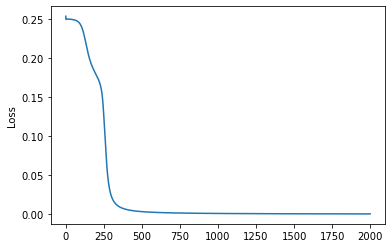

In [10]:
import matplotlib.pyplot as plt

plt.plot(all_losses)
plt.ylabel('Loss')
plt.show()

We can now check the network parameters:

In [21]:
# show weights and bias
for name, param in xor_network.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear_xor_stack.0.weight tensor([[-6.3393, -7.7753],
        [-4.4129, -4.5393]])
linear_xor_stack.0.bias tensor([2.6273, 6.6014])
linear_xor_stack.2.weight tensor([[-9.4410,  9.2608]])
linear_xor_stack.2.bias tensor([-4.3407])


## Check the model

Let's check if the model behaves as expected:

In [12]:
# test input
input = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])
out = xor_network.forward(input)
print(out.round())

tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<RoundBackward>)
